In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [52]:
# Konfigurasi menentukan Direktori Dataset
main_dataset_dir = 'dataset_split'
train_dir = os.path.join(main_dataset_dir, 'train')
val_dir = os.path.join(main_dataset_dir, 'val')
test_dir = os.path.join(main_dataset_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

In [53]:
#Image Data Generator preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],         # Tambah variasi pencahayaan
    shear_range=0.2,                     # Sedikit distorsi
    width_shift_range=0.1,              # Perpindahan horizontal
    height_shift_range=0.1,             # Perpindahan vertikal
    channel_shift_range=30.0,           # Ubah sedikit channel warna RGB
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def get_generator(directory, augment=False):
    datagen = train_datagen if augment else val_test_datagen
    return datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )


In [54]:
#Load Dataset
train_gen = get_generator(train_dir, augment=True)
val_gen = get_generator(val_dir)
test_gen = get_generator(test_dir)

Found 714 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
Found 153 images belonging to 3 classes.


In [55]:
#Load Pretrained MobileNetV2 (tanpa top)
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False,
                          input_shape=(img_height, img_width, 3), pooling='avg')

#Ekstraksi Fitur MobileNetV2
def extract_features(generator, name=''):
    print(f"\n🔍 Ekstraksi fitur untuk {name}...")
    features = mobilenetv2.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train, y_train = extract_features(train_gen, name='Training')
X_val, y_val = extract_features(val_gen, name='Validation')
X_test, y_test = extract_features(test_gen, name='Testing')


🔍 Ekstraksi fitur untuk Training...


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step

🔍 Ekstraksi fitur untuk Validation...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 763ms/step

🔍 Ekstraksi fitur untuk Testing...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 737ms/step


In [56]:
#Normalisasi fitur (Menyamakan skala untuk algoritma  SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [57]:
# Inisialisasi dan pelatihan model SVM (kernel linear)
svm = SVC(kernel='linear', C = 0.1, probability=True)
svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True)


📊 Evaluasi pada Data Validasi:
                  precision    recall  f1-score   support

     cabai busuk       0.98      0.98      0.98        51
cabai_antraknosa       0.98      0.98      0.98        51
     cabai_sehat       0.98      0.98      0.98        51

        accuracy                           0.98       153
       macro avg       0.98      0.98      0.98       153
    weighted avg       0.98      0.98      0.98       153

Akurasi  : 0.9804
Precision: 0.9804
Recall   : 0.9804
F1-score : 0.9804


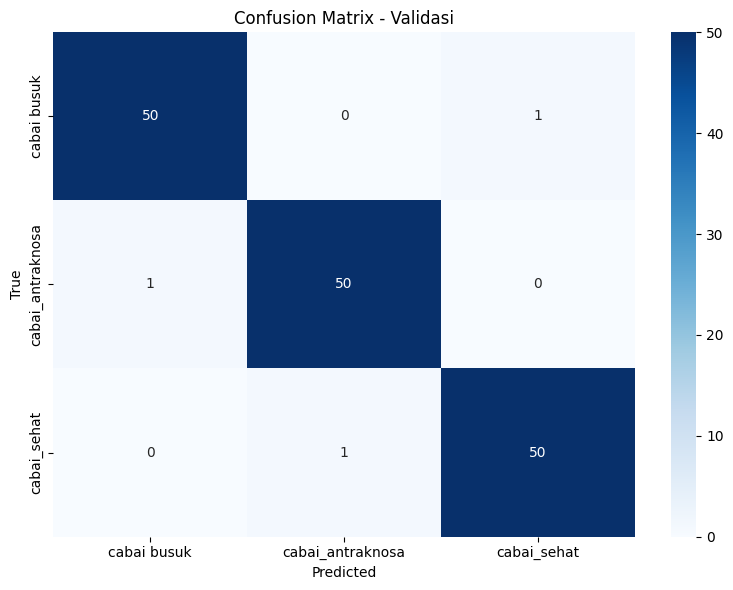

In [58]:
#Evaluasi pada Data Validasi
y_val_pred = svm.predict(X_val)

print("\n📊 Evaluasi pada Data Validasi:")
print(classification_report(y_val, y_val_pred, target_names=val_gen.class_indices.keys()))
print(f"Akurasi  : {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"F1-score : {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys(),
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validasi')
plt.tight_layout()
plt.show()


📊 Hasil Evaluasi pada data Test:
                  precision    recall  f1-score   support

     cabai busuk       1.00      1.00      1.00        51
cabai_antraknosa       1.00      1.00      1.00        51
     cabai_sehat       1.00      1.00      1.00        51

        accuracy                           1.00       153
       macro avg       1.00      1.00      1.00       153
    weighted avg       1.00      1.00      1.00       153

Akurasi  : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000


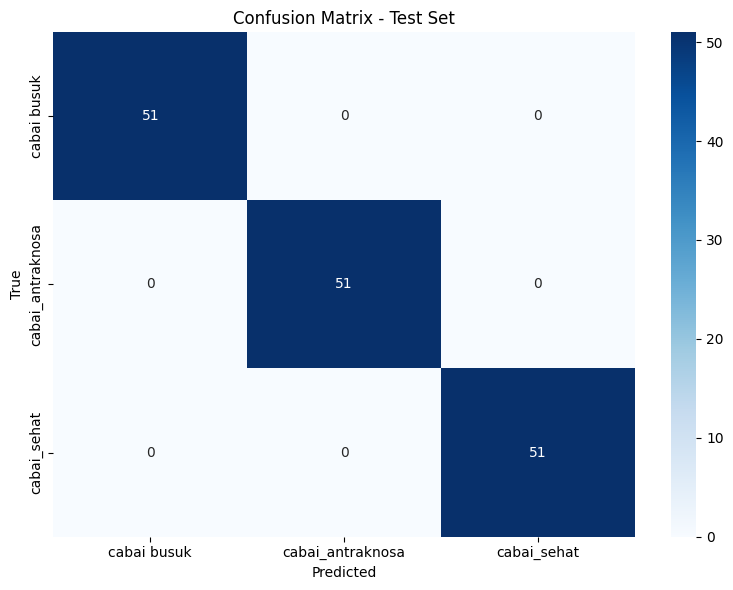

In [59]:
#Evaluasi Model pada data Test
y_test_pred = svm.predict(X_test)

print("\n📊 Hasil Evaluasi pada data Test:")
print(classification_report(y_test, y_test_pred, target_names=test_gen.class_indices.keys()))
print(f"Akurasi  : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1-score : {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys(),
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()



✅ Gambar BENAR diklasifikasikan :


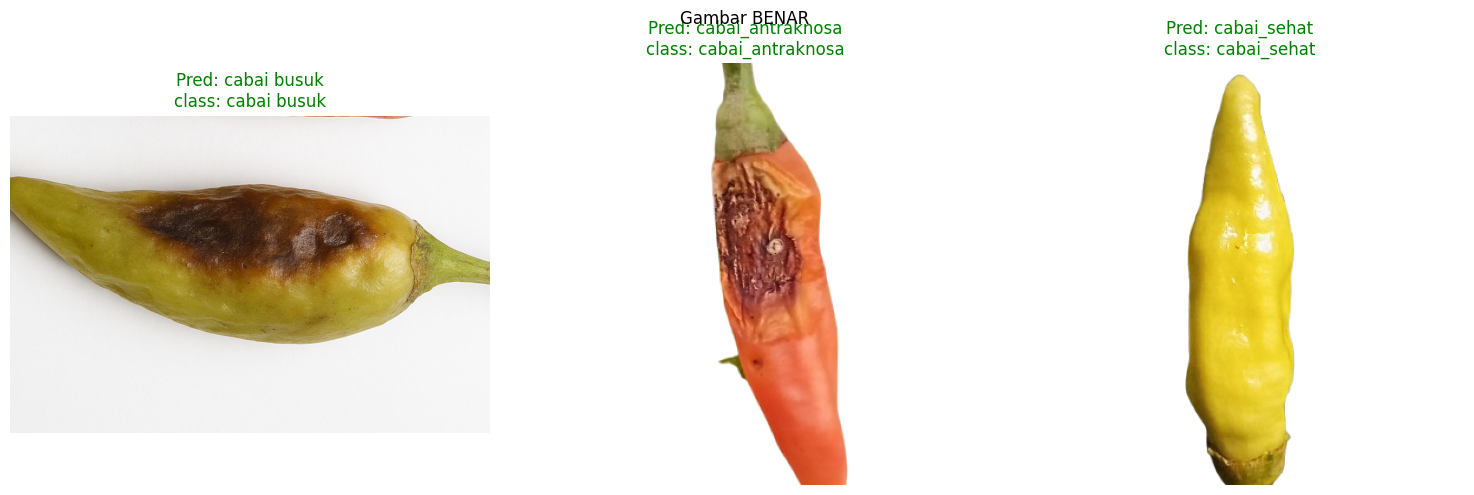


❌ Gambar SALAH diklasifikasikan :


<Figure size 1500x500 with 0 Axes>

In [60]:
# === Visualisasi Hasil Klasifikasi ===
class_names = list(test_gen.class_indices.keys())
filepaths = test_gen.filepaths

# Baca ulang gambar asli dari path absolut
images = [plt.imread(os.path.join(os.getcwd(), path)) for path in filepaths]

correct_idx = np.where(y_test == y_test_pred)[0]
incorrect_idx = np.where(y_test != y_test_pred)[0]

# Ambil contoh dari setiap kelas
def get_representative_indices(indices, y_labels, n_per_class=1):
    """Ambil n_per_class contoh dari setiap kelas berdasarkan indeks yang diberikan"""
    class_indices = {label: [] for label in np.unique(y_labels)}
    for idx in indices:
        label = y_labels[idx]
        if len(class_indices[label]) < n_per_class:
            class_indices[label].append(idx)
    selected = []
    for idxs in class_indices.values():
        selected.extend(idxs)
    return selected

# Visualisasi: gambar dari setiap kelas yang diklasifikasikan BENAR
selected_correct = get_representative_indices(correct_idx, y_test, n_per_class=1)
# Visualisasi: gambar dari setiap kelas yang diklasifikasikan SALAH
selected_incorrect = get_representative_indices(incorrect_idx, y_test, n_per_class=2)

def plot_images(indices, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(images[idx])
        true_label = class_names[int(y_test[idx])]
        pred_label = class_names[int(y_test_pred[idx])]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"Pred: {pred_label}\nclass: {true_label}", color=color)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("\n✅ Gambar BENAR diklasifikasikan :")
plot_images(selected_correct, "Gambar BENAR")

print("\n❌ Gambar SALAH diklasifikasikan :")
plot_images(selected_incorrect, "Gambar SALAH")
